In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
%matplotlib inline 

There are three gages downstream of F-12-AV which have peak discharge records

1. 06710992 is 2 miles downstream of F-12-AV (watershed size = 45.9 sq mi)

2. 06710995 is 4 miles downstream of F-12-AV (watershed size =  47.4 sq mi)

3. 06711000 is 6 miles downstream of F-12-AV (watershed size = 50.1 sq mi)

In [10]:
sites = ['F-12-AV', '06711000', '06710992', '06710995']
lat = [39.592528  , 39.635556  , 39.6174879 , 39.62026566]
long = [-105.222333 , -105.168056 , -105.2238786, -105.1952666]
area = [24.6, 50.1, 45.9, 47.4]

In [4]:
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.tile_providers import CARTODBPOSITRON, get_provider
from bokeh.models import ColumnDataSource
from bokeh.models.tools import HoverTool

In [5]:
output_notebook()

Loading BokehJS ...

In [6]:
def wgs84_to_web_mercator(x, y):
    if isinstance(x, list):
        x = np.array(x)
        y = np.array(y)
    lat = x
    lon = y
    
    r_major = 6378137.000
    x = r_major * np.radians(lon)
    scale = x/lon
    y = 180.0/np.pi * np.log(np.tan(np.pi/4.0 + lat * (np.pi/180.0)/2.0)) * scale
    return x, y

In [7]:
x, y = wgs84_to_web_mercator(lat, long)

# plotting parameters
scale = 20
x_min=int(x.mean() - (scale * 350))
x_max=int(x.mean() + (scale * 350))
y_min=int(y.mean() - (scale * 350))
y_max=int(y.mean() + (scale * 350))

* The locations of the gages

In [11]:
tile_provider = get_provider('OSM')

p = figure(x_range=(x_min, x_max), y_range=(y_min, y_max), x_axis_type='mercator', y_axis_type='mercator')
p.add_tile(tile_provider)

source = ColumnDataSource(
    data=dict(name = sites, x=x, y=y, lat=lat, lon=long, area=area)
)

c = p.circle(x="x", y="y", size=10, fill_color="blue", fill_alpha=0.8, source=source)
c_hover = HoverTool(tooltips=[('Name', '@name'),('Lat','@lat'),('Lon','@lon'),('Area (sq mi)','@area')],mode='mouse',point_policy='follow_mouse',renderers=[c])
c_hover.renderers.append(c)
p.tools.append(c_hover)

show(p)

In [12]:
def get_peak(sitno):
    url = 'http://nwis.waterdata.usgs.gov/nwis/peak?site_no={}&agency_cd=USGS&format=rdb'.format(sitno)
    df = pd.read_csv(url, comment='#', sep='\t')
    df.drop(0,inplace=True)
    df.reset_index(inplace=True, drop=True)
    df['peak_va'] = pd.to_numeric(df['peak_va'], errors='coerce')
    df['gage_ht'] = pd.to_numeric(df['gage_ht'], errors='coerce')    
    try:
        df['peak_dt'] = pd.to_datetime(df['peak_dt'])
    except:
        pass
    return df[df.columns[[2,4,6]]]

In [14]:
peak_tables = []

for site in sites[1:]:
    peak_tables.append(get_peak(site))

In [18]:
from matplotlib.ticker import AutoMinorLocator

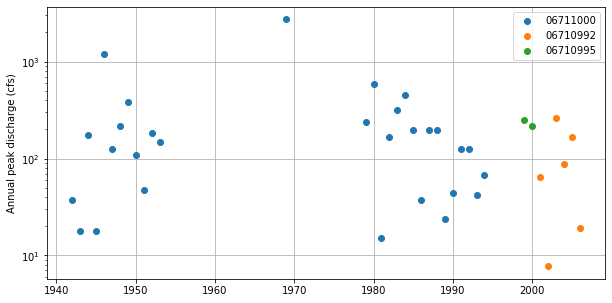

In [25]:
df = peak_tables[0]
df['year'] = df['peak_dt'].str[:4].astype(int)
df.at[1, 'year'] = 1943

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(df.year, df.peak_va, 'o', label=sites[1])
ax.plot(peak_tables[1].peak_dt.dt.year, peak_tables[1].peak_va, 'o', label=sites[2])
ax.plot(peak_tables[2].peak_dt.dt.year, peak_tables[2].peak_va, 'o', label=sites[3])
ax.set_ylabel('Annual peak discharge (cfs)')
ax.set_yscale('log')
#ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.grid()
ax.legend()